### Workflow and Thought Process

Step 1: Get the data into the right layout.
- Always think tabular first
- Rows are observations / samples
- Columns are variables / features

```
# Load the data into pandas using the correct file type.

df = pd.read_csv(...)  # csv
df = pd.read_excel(..., sheetname=...)  # excel
df = pd.read_parquet(...)  # parquet

# and 16 other formats including spss and sql.
# ## See here: https://pandas.pydata.org/docs/user_guide/io.html
```

```
# Perform data wrangling to get the correct layout.
# ## There is no shame in using GenAI (ChatGPT, Claude, Gemini)

df = df.apply(lambda x: ..., axis=1)
```

Step 2: Explore the data
- Interpret features and form inital hypotheses
- Observations are used to compute summary statistics for inspection
- "Visualize" the problem and solution

```
# Create a profile report of the dataframe
# ## Inspect for anomalies and build a sense of the feature space and
# ## form an initial set of hypotheses

df.profile_report(minimal=True)
```

Step 3: Identify what you want to predict and what you want to predict with:

**Predictive outcome**
- A value: Regression
- A label (i.e., a choice from a set of candidate choices): Classification

**Features**
- Features to ignore (lookahead-bias, i.e., values that you will not observe on prediction day. Example, I want to predict price_psf and there are price_psm, transaction_price, and nett_price in the features. These must be ignored.)
- Features that should be numerical
- Features that should be categorical
- For classification, is there data imbalance in the outcome feature? Use fix_imbalance if True.
- For classification, ensure data_split_stratify is True so that the train and test datasets have the same proportion of outcome labels
- If there are important features that have different proportion in feature lables, pass the feature names as a list to data_split_stratify, which will ensure that the train and test datasets have similar proportions of the feature labels as well.
- Consider the need for preprocessing (normalize, transformation, polynomial features).

```
# Instantiate an experiment class
exp = RegressionExperiment()  # or
exp = ClassificationExperiment()

# Setup the experiment
exp.setup(
    data=df,
    target=...,
    fix_imbalance=True,
    data_split_stratify=True,
    ignore_features=[...],
    ...,
    session_id = 137,
    log_experiment=True,
    experiment_name='...',
)

# See pycaret documentation: https://pycaret.gitbook.io/docs
```

Step 4: Use the data and fit into models that are known to be:
- Easy to understand: Linear/Logistic Regression, Decision Trees
- Good predictive performance: Ensembles
- Adjusts for overfitting: Ensembles, Penalized Regressions

```
# Fit the data across all classes of models
exp.compare_models()

# Choose the best models
best_model = exp.create_model(...)
lgb = exp.create_model('lgb')
xgb = exp.create_model('xgb')
```

Step 5: Analyze the performance of the models
- Feature importances: Does the important features make sense?
- Error distribution: What segment of the data tend to have larger errors?
- Learning curves: Will more samples help, or do we need more features?

```
# Validate the model performance on the test set
exp.predict_model(best_model)

# Inspect the model performance
exp.evaluate_model(best_model)

# Get a shap diagram to inform hypotheses
exp.interpret_model(best_model)
```

Step 6: Improve the solution
- More data and more relevant features
- Use stacking or blending ensembles
- Tune the model hyperparameters
- Insert more intermediate steps into the ML pipeline
- Better explanation

```
# Stack or blend multiple models
stack_ensemble = exp.stack_models(...)
blend_ensemble = exp.blend_models(...)

# Tune models (may or may not improve)
tuned_model = exp.tune_model(
    best_model,
    choose_better=True,
    search_library='optuna',
    n_iter=200,
    optimize='<metric>',
    early_stopping=True
)
```

Step 7: Maintain a proper pipeline management
- MLOps to manage data and model versions, performance, and other related artifacts

```
!mlflow ui
```

Step 8: Prepare for deployment
- Train the model on all data
- Save the trained model into a file or
- Use MLFlow model versioning

```
# Finalize the model by training it with all data
final_model = exp.finalize_model(tuned_model)

# Save the final model
# ## Use datetime.now() to ensure that we can trace every model version
model_filename = f'final_model_{datetime.datetime.now().strftime("%Y%m%d-%H%M%S")}'

# ## Save the model
exp.save_model(final_model, model_filename)
```

Step 9: Create an interface for ease of operation
- API service
- Dashboard

```
from pycaret.... import load_model, predict_model

# Load latest model
latest_model = load_model(model_filename)

# Insert prediction code into interface code
# ## Convert input data into pandas dataframe
input_df = pd.DataFrame(...)

# ## Get predicted value
predicted_value = latest_model.predict_model(input_df)
```



# Setup

### Allow GPU for traditional machine learning
The following cells installs the lightgbm gpu version as well as cuml from rapids.ai.

These are required if we want to run traditional machine learning models with GPU.

Note that deep learning packages (e.g., pytorch, tensorflow) comes with native GPU access. There is no need to install anything else.

In [ ]:
# LightGBM GPU can be activated with the following script
!mkdir -p /etc/OpenCL/vendors && echo "libnvidia-opencl.so.1" > /etc/OpenCL/vendors/nvidia.icd

/bin/bash: /etc/OpenCL/vendors/nvidia.icd: Permission denied


In [ ]:
# For some ML models, we require rapids ai's cuml
%pip install --extra-index-url=https://pypi.nvidia.com cuml-cu12==24.10.*

Looking in indexes: https://pypi.org/simple, https://pypi.nvidia.com
Note: you may need to restart the kernel to use updated packages.


### Other required installations

In [ ]:
# Install the additional packages
# ## If we install the packages in a single row, it will perform dependency version checks
# ## else, the later packages will replace the dependencies of the earlier packages
# !pip install ydata_profiling swifter
# !pip install pycaret[full]
# !pip install scikit-learn-intelex
# !pip install fastapi[all] mlflow pyngrok
%pip install plotly
%pip install pillow
%pip install ydata_profiling swifter
%pip install pycaret[full]
%pip install scikit-learn-intelex
%pip install fastapi[all] mlflow pyngrok

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


### Imports and data connectivity

In [1]:
# All import statements should be upfront so that it is easy to
# track what are required

# ## Import the following packages
import datetime
import swifter
import mlflow
import pandas as pd
import numpy as np
import plotly.express as px
from tqdm.notebook import tqdm
from pathlib import Path
from pydantic import BaseModel
from ydata_profiling import ProfileReport
from pycaret.regression import RegressionExperiment
from pycaret.classification import ClassificationExperiment

In [2]:
# Connect to data folder
try:
    from google.colab import userdata
    from google.colab import drive
    drive.mount('/content/drive')

    data_dir = Path('/content/drive/MyDrive/pcml_data/5SML')
    mlrun_dir = Path('/content/drive/MyDrive/logs/mlruns')
    model_dir = Path('/content/drive/MyDrive/Colab Notebooks/models')

except (NotImplementedError,ModuleNotFoundError):
    data_dir = Path('data/5SML')
    mlrun_dir = Path('logs/mlruns')
    model_dir = Path('models')

else:
    print(f'Using Colab...')
    print(data_dir.exists())
    print(mlrun_dir.exists())

finally:
    if not mlrun_dir.exists():
        mlrun_dir.mkdir(parents=True)
    mlflow.set_tracking_uri(mlrun_dir)

### Step 1: Working with data:
- Source the dataset
- Load the dataset
- Wrangle the dataset into a tabular layout, if required

In [3]:
# Read parquet file into dataframe
# 'housing_transactions_processed.parquet'
# 'sg_resi_data'/'resi_sales_full.parquet'
file_path = f'{data_dir}/sg_resi_data/resi_sales_full.parquet'
print(file_path)
df = pd.read_parquet(file_path)
# df = pd.read_parquet(data_dir / 'housing_transactions_processed.parquet')
print(df.head())


data/5SML/sg_resi_data/resi_sales_full.parquet
             project_name transacted_price area_sqft price_psf    sale_date  \
0         EASTPOINT GREEN        1,600,000  2,098.98       762  01 Nov 2019   
1           THE INTERLACE        1,400,000  1,065.64     1,314  01 Nov 2019   
2  AVENUE SOUTH RESIDENCE        1,232,000     656.6     1,876  01 Nov 2019   
3      HOLLAND RESIDENCES        2,625,000  1,356.26     1,935  01 Nov 2019   
4             KIMNAN PARK        3,900,000  3,447.71     1,131  01 Nov 2019   

                   address type_of_sale type_of_area area_sqm price_psm  ...  \
0  1 SIMEI STREET 3 #09-03       Resale       Strata      195     8,205  ...   
1    200 DEPOT ROAD #04-40       Resale       Strata       99    14,141  ...   
2   13 SILAT AVENUE #12-45     New Sale       Strata       61    20,197  ...   
3     3 TAMAN WARNA #03-08       Resale       Strata      126    20,833  ...   
4        7 TAMAN KEMBANGAN       Resale         Land    320.3    12,176  ...  

In [4]:
# Rename the feature names to the following labels
# print(df.head())
label_rename_map = {
    'Project Name': 'project_name',
    'Address': 'address',
    'Number of Units': 'no_of_units',
    'Area (SQM)': 'area_sqm',
    'Area (SQFT)': 'area_sqft',
    'Type of Area': 'type_of_area',
    'Transacted Price ($)': 'transacted_price',
    'Nett Price($)': 'nett_price',
    'Unit Price ($ PSM)': 'price_psm',
    'Unit Price ($ PSF)': 'price_psf',
    'Sale Date': 'sale_date',
    'Property Type': 'property_type',
    'Tenure': 'tenure',
    'Completion Date': 'completion_date',
    'Type of Sale': 'type_of_sale',
    'Purchaser Address Indicator': 'purchaser_address_indicator',
    'Postal District': 'postal_district',
    'Postal Sector': 'postal_sector',
    'Postal Code': 'postal_code',
    'Planning Region': 'planning_region',
    'Planning Area': 'planning_area'
}
# Apply the new names to the dataframe
df = df.rename(columns=label_rename_map)
print(df.head())

             project_name transacted_price area_sqft price_psf    sale_date  \
0         EASTPOINT GREEN        1,600,000  2,098.98       762  01 Nov 2019   
1           THE INTERLACE        1,400,000  1,065.64     1,314  01 Nov 2019   
2  AVENUE SOUTH RESIDENCE        1,232,000     656.6     1,876  01 Nov 2019   
3      HOLLAND RESIDENCES        2,625,000  1,356.26     1,935  01 Nov 2019   
4             KIMNAN PARK        3,900,000  3,447.71     1,131  01 Nov 2019   

                   address type_of_sale type_of_area area_sqm price_psm  ...  \
0  1 SIMEI STREET 3 #09-03       Resale       Strata      195     8,205  ...   
1    200 DEPOT ROAD #04-40       Resale       Strata       99    14,141  ...   
2   13 SILAT AVENUE #12-45     New Sale       Strata       61    20,197  ...   
3     3 TAMAN WARNA #03-08       Resale       Strata      126    20,833  ...   
4        7 TAMAN KEMBANGAN       Resale         Land    320.3    12,176  ...   

         property_type no_of_units          

In [5]:
# Enbloc and block purchases do not accurately reflect the price that most
# purchasers face, thus we should remove observations with no_of_units more than 1
print(set(df['no_of_units']))
# df = df[df['no_of_units'] == 1]
df = df[df['no_of_units'] == 1]
print(set(df['no_of_units']))

{1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 40, 41, 43, 44, 45, 46, 47, 48, 560, 50, 51, 52, 49, 54, 55, 56, 57, 58, 60, 61, 63, 64, 65, 67, 68, 70, 71, 72, 583, 73, 76, 78, 79, 80, 81, 83, 84, 86, 88, 89, 91, 92, 607, 96, 98, 100, 102, 104, 106, 618, 108, 114, 117, 118, 120, 124, 138, 139, 144, 160, 164, 165, 168, 175, 176, 180, 185, 186, 188, 192, 193, 200, 210, 218, 244, 255, 286, 288, 290, 314, 330, 336, 358, 436, 446}
{1}


In [6]:
# Remove landed properties since their purchase is restricted to residents,
# while foreigners can still buy condominiums.
# see before
print(set(df["property_type"]))
# Filter out rows where 'property_type' contains "House"
df = df[~df['property_type'].str.contains('House', case=False, na=False)]
# see after
print(set(df["property_type"]))

{'Terrace House', 'Condominium', 'Executive Condominium', 'Semi-Detached House', 'Apartment', 'Detached House'}
{'Executive Condominium', 'Condominium', 'Apartment'}


In [7]:
# Remove Unknown in completion date and set the year to 2023 for Uncompleted
print(set(df['completion_date']))
# Remove rows where 'completion_date' is "Unknown"
df = df[df['completion_date'] != 'Unknown']
df = df[df['completion_date'] != '-']
print(set(df['completion_date']))

{'2000', '2007', '1966', '2011', '2009', '1984', '1956', '2003', '1980', '2018', '1975', '1988', '1998', '1985', '1978', '1981', 'Uncompleted', '1963', '1999', '2006', '1990', '1995', '2002', '1987', '1967', 'Uncomplete', '1964', '1952', '1961', '2023', '2016', '1997', '2010', '1972', '2012', '1953', '1996', '1965', '1962', '1986', '2022', '2019', '1970', '1992', '1991', '2001', '1969', '1954', '1979', '1957', '1993', '2008', '1977', '1976', '2005', '2004', '1960', '2020', '1973', '1974', '1971', '2021', '1994', '1968', '-', '2013', '2024', '1982', '1959', '2015', '1955', '2014', '1989', '1983', '2017'}
{'2000', '2007', '1966', '2011', '2009', '1984', '1956', '2003', '1980', '2018', '1975', '1988', '1998', '1985', '1978', '1981', 'Uncompleted', '1963', '1999', '2006', '1990', '1995', '2002', '1987', '1967', 'Uncomplete', '1964', '1952', '1961', '2023', '2016', '1997', '2010', '1972', '2012', '1953', '1996', '1965', '1962', '1986', '2022', '2019', '1970', '1992', '1991', '2001', '1969',

In [8]:
# All uncompleted units will have its year set to 2023
print(set(df['completion_date']))
df.loc[df['completion_date'].str.contains('uncomplete', case=False, na=False), 'completion_date'] = '2023'
print(set(df['completion_date']))

{'2000', '2007', '1966', '2011', '2009', '1984', '1956', '2003', '1980', '2018', '1975', '1988', '1998', '1985', '1978', '1981', 'Uncompleted', '1963', '1999', '2006', '1990', '1995', '2002', '1987', '1967', 'Uncomplete', '1964', '1952', '1961', '2023', '2016', '1997', '2010', '1972', '2012', '1953', '1996', '1965', '1962', '1986', '2022', '2019', '1970', '1992', '1991', '2001', '1969', '1954', '1979', '1957', '1993', '2008', '1977', '1976', '2005', '2004', '1960', '2020', '1973', '1974', '1971', '2021', '1994', '1968', '2013', '2024', '1982', '1959', '2015', '1955', '2014', '1989', '1983', '2017'}
{'2000', '2007', '1966', '2011', '2009', '1984', '1956', '2003', '1980', '2018', '1975', '1988', '1998', '1985', '1978', '1981', '1963', '1999', '2006', '1990', '1995', '2002', '1987', '1967', '2023', '1964', '1961', '1952', '2016', '1997', '2010', '1972', '2012', '1953', '1996', '1965', '1962', '1986', '2022', '2019', '1970', '1992', '1991', '2001', '1969', '1954', '1979', '1957', '1993', '

In [9]:
# Convert sale date to a proper datetime form
print(set(df['sale_date']))
df['sale_date'] = pd.to_datetime(df['sale_date'], errors='coerce')
print(set(df['sale_date']))

{'27 Dec 2023', '06 Jun 2003', '02 Oct 2006', '30 Oct 2019', '10 Sep 2009', '07 Sep 2009', '03 Sep 2000', '02 Dec 1996', '05 Apr 2003', '22 Jun 2000', '10 Sep 1996', '04 Sep 2003', '03 Jan 2005', '11 Apr 1999', '12 May 2011', '22 Nov 2003', '24 May 1997', '20 May 2008', '03 Jul 2014', '25 Jun 2020', '21 Jan 2019', '24 Jan 1997', '07 Apr 2010', '01 May 1996', '10 Jul 2018', '28 Dec 2010', '06 May 2017', '30 Nov 2017', '16 Apr 2012', '04 Dec 2020', '04 Jun 2004', '21 Jul 2018', '24 Apr 2001', '10 Mar 2000', '02 Jul 2011', '06 Feb 2017', '07 Sep 2005', '22 Jan 2007', '31 Aug 2005', '12 Jun 2008', '09 May 2005', '05 Mar 2008', '13 Mar 2008', '07 Jul 2021', '28 Nov 1995', '26 Feb 2009', '05 Jul 2000', '18 May 1997', '01 Dec 2021', '02 Jun 1995', '16 Jun 2000', '15 Apr 2003', '20 Aug 2012', '05 Feb 2001', '30 Jan 2007', '12 Jul 2000', '23 Nov 2009', '26 Dec 1998', '19 Jul 2020', '15 Sep 1998', '06 Sep 1999', '07 Apr 2000', '25 Apr 2021', '28 Apr 2005', '17 Feb 2020', '04 Sep 2004', '18 Jun 2

In [10]:
# Create a reference date, where the earliest date in the dataset is 0 and each
# subsequent date increases by 1

# This will allow decision trees to group observations by dates in a very fine
# manner - Trend capturing.

# First get a de-duplicated list of sale date
print(list(df['sale_date']))
df_sale_date = df['sale_date'].drop_duplicates()
# ## Then sort them
print(list(df_sale_date))
df_sale_date = df_sale_date.sort_values().reset_index(drop=True)
# ## Then create a incremental date using i += 1 for each consecutive date
print(list(df_sale_date))
date_mapping = {date: idx for idx, date in enumerate(df_sale_date)}
print(date_mapping)

IOPub data rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_data_rate_limit`.

Current values:
ServerApp.iopub_data_rate_limit=2000000.0 (bytes/sec)
ServerApp.rate_limit_window=3.0 (secs)



In [ ]:
# Apply the date dictionary to the dataframe and call this date feature date_id.
df['date_id'] = df['sale_date'].map(date_mapping)
print(df.head())

             project_name transacted_price area_sqft price_psf  sale_date  \
0         EASTPOINT GREEN        1,600,000  2,098.98       762 2019-11-01   
1           THE INTERLACE        1,400,000  1,065.64     1,314 2019-11-01   
2  AVENUE SOUTH RESIDENCE        1,232,000     656.6     1,876 2019-11-01   
3      HOLLAND RESIDENCES        2,625,000  1,356.26     1,935 2019-11-01   
5      CLOVER BY THE PARK        2,238,000  1,743.77     1,283 2019-11-01   

                     address type_of_sale type_of_area area_sqm price_psm  \
0    1 SIMEI STREET 3 #09-03       Resale       Strata      195     8,205   
1      200 DEPOT ROAD #04-40       Resale       Strata       99    14,141   
2     13 SILAT AVENUE #12-45     New Sale       Strata       61    20,197   
3       3 TAMAN WARNA #03-08       Resale       Strata      126    20,833   
5  6 BISHAN STREET 25 #34-13       Resale       Strata      162    13,815   

   ... no_of_units                  tenure  completion_date  \
0  ...     

In [ ]:
# Create leasehold/freehold dummy
# First, drop all rows where tenure is null
print(set(df["tenure"]))
df = df.dropna(subset=['tenure'])

# Then, check what are the various tenures in the dataset
print(set(df["tenure"]))


{'99 yrs from 05/03/2004', '99 yrs from 02/04/1998', '99 yrs from 01/04/1978', '99 yrs from 01/09/1991', '999 yrs from 19/05/1883', '99 yrs from 30/08/1976', '99 yrs from 10/01/2012', '99 yrs from 20/03/1998', '103 yrs from 28/11/2002', '99 yrs from 08/09/2010', '99 yrs from 26/08/2011', '99 yrs from 17/07/2017', '99 yrs from 25/05/2012', '99 yrs from 20/08/1982', '99 yrs from 26/09/2011', '99 yrs from 15/02/2021', '99 yrs from 28/04/2023', '99 yrs from 29/06/2015', '99 yrs from 18/07/1997', '99 yrs from 21/02/2011', '99 yrs from 23/11/2021', '99 yrs from 14/08/2000', '99 yrs from 20/06/2003', '999 yrs from 10/06/1885', '99 yrs from 28/04/2014', '99 yrs from 25/04/2022', '99 yrs from 20/10/2010', '99 yrs from 06/01/2012', '99 yrs from 03/01/2006', '999 yrs from 24/11/1995', '99 yrs from 27/06/2007', '99 yrs from 31/08/2021', '99 yrs from 07/05/2013', '99 yrs from 24/05/2010', '99 yrs from 31/10/2007', '99 yrs from 22/09/1997', '99 yrs from 29/07/2014', '99 yrs from 07/04/1975', '99 yrs

In [ ]:
# Create leasehold dummy feature
def is_leasehold(x):
    return 0 if 'freehold' in str(x).lower() else 1
print(df.head())
# Apply is_leasehold to the data feature
df['leasehold_dummy'] = df['tenure'].apply(is_leasehold)
print(df.head())


             project_name transacted_price area_sqft price_psf  sale_date  \
0         EASTPOINT GREEN        1,600,000  2,098.98       762 2019-11-01   
1           THE INTERLACE        1,400,000  1,065.64     1,314 2019-11-01   
2  AVENUE SOUTH RESIDENCE        1,232,000     656.6     1,876 2019-11-01   
3      HOLLAND RESIDENCES        2,625,000  1,356.26     1,935 2019-11-01   
5      CLOVER BY THE PARK        2,238,000  1,743.77     1,283 2019-11-01   

                     address type_of_sale type_of_area area_sqm price_psm  \
0    1 SIMEI STREET 3 #09-03       Resale       Strata      195     8,205   
1      200 DEPOT ROAD #04-40       Resale       Strata       99    14,141   
2     13 SILAT AVENUE #12-45     New Sale       Strata       61    20,197   
3       3 TAMAN WARNA #03-08       Resale       Strata      126    20,833   
5  6 BISHAN STREET 25 #34-13       Resale       Strata      162    13,815   

   ... no_of_units                  tenure  completion_date  \
0  ...     

In [ ]:
# Merge lat/lon data to postal code
# First, read the postal code - lat/lon pickle data
# ## pickle is an inbuilt package that stores python objects
# data_dir
import pickle
# postal_lat_lon = pickle.load(open(data_dir / 'postal_lat_lon.pkl', 'rb'))

postal_lat_lon = pickle.load(open(f'{data_dir}/sg_resi_data/postal_lat_lon.pkl', 'rb'))
print(postal_lat_lon)

IOPub data rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_data_rate_limit`.

Current values:
ServerApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
ServerApp.rate_limit_window=3.0 (secs)



In [ ]:
# Extract all the postal codes from df and use it to filer postal lat lon
# Then create a dataframe of postal lat lon with postal code, lat, and lon
df_postal_code = df['postal_code'].drop_duplicates()
print(df_postal_code)

# print(postal_lat_lon['529890']['results'])

# for item in postal_lat_lon['529890']['results']:
#     latitude = item.get('LATITUDE')
#     longitude = item.get('LONGITUDE')
#     print(f"Latitude: {latitude}, Longitude: {longitude}")

postal_lat_lon_df = pd.DataFrame(columns=['postal_code', 'lat', 'lon'])
for index, row in df_postal_code.items():
    postal_code = df_postal_code[index]
    if postal_code in postal_lat_lon:
        for item in postal_lat_lon[postal_code]['results']:
            latitude = item.get('LATITUDE')
            longitude = item.get('LONGITUDE')
            postal_lat_lon_df = pd.concat([postal_lat_lon_df, pd.DataFrame({'postal_code': [postal_code], 'lat': [latitude], 'lon': [longitude]})], ignore_index=True)

print(postal_lat_lon_df)


0         529890
1         109694
2         168878
3         276340
5         573975
           ...  
639273    218671
641344    369739
644267    249111
646232    287168
646643    289541
Name: postal_code, Length: 7728, dtype: object
     postal_code               lat               lon
0         529890  1.33954520418255  103.951022111706
1         109694  1.28221769648724  103.803662042285
2         168878  1.27674860205667  103.829703394306
3         276340  1.31092721897706  103.799276754339
4         573975  1.35995510910579  103.846306946336
...          ...               ...               ...
8523      287168  1.33077830599642   103.80925359622
8524      289541  1.33410884555428  103.799023761242
8525      289541  1.33410884500683  103.799023761514
8526      289541  1.33410884500683  103.799023761514
8527      289541  1.33410884500683  103.799023761514

[8528 rows x 3 columns]


In [ ]:
# Merge lat/lon to dataframe
df = df.merge(postal_lat_lon_df, on='postal_code', how='left')
print(df.head())

             project_name transacted_price area_sqft price_psf  sale_date  \
0         EASTPOINT GREEN        1,600,000  2,098.98       762 2019-11-01   
1           THE INTERLACE        1,400,000  1,065.64     1,314 2019-11-01   
2  AVENUE SOUTH RESIDENCE        1,232,000     656.6     1,876 2019-11-01   
3      HOLLAND RESIDENCES        2,625,000  1,356.26     1,935 2019-11-01   
4      CLOVER BY THE PARK        2,238,000  1,743.77     1,283 2019-11-01   

                     address type_of_sale type_of_area area_sqm price_psm  \
0    1 SIMEI STREET 3 #09-03       Resale       Strata      195     8,205   
1      200 DEPOT ROAD #04-40       Resale       Strata       99    14,141   
2     13 SILAT AVENUE #12-45     New Sale       Strata       61    20,197   
3       3 TAMAN WARNA #03-08       Resale       Strata      126    20,833   
4  6 BISHAN STREET 25 #34-13       Resale       Strata      162    13,815   

   ... purchaser_address_indicator postal_code  postal_district postal_sec

In [ ]:
# Remove rows that have no lat/lon
df = df.dropna(subset=['lat', 'lon'])
print(df.head())

             project_name transacted_price area_sqft price_psf  sale_date  \
0         EASTPOINT GREEN        1,600,000  2,098.98       762 2019-11-01   
1           THE INTERLACE        1,400,000  1,065.64     1,314 2019-11-01   
2  AVENUE SOUTH RESIDENCE        1,232,000     656.6     1,876 2019-11-01   
3      HOLLAND RESIDENCES        2,625,000  1,356.26     1,935 2019-11-01   
4      CLOVER BY THE PARK        2,238,000  1,743.77     1,283 2019-11-01   

                     address type_of_sale type_of_area area_sqm price_psm  \
0    1 SIMEI STREET 3 #09-03       Resale       Strata      195     8,205   
1      200 DEPOT ROAD #04-40       Resale       Strata       99    14,141   
2     13 SILAT AVENUE #12-45     New Sale       Strata       61    20,197   
3       3 TAMAN WARNA #03-08       Resale       Strata      126    20,833   
4  6 BISHAN STREET 25 #34-13       Resale       Strata      162    13,815   

   ... purchaser_address_indicator postal_code  postal_district postal_sec

In [ ]:
# Convert integer like features to float (e.g. 1,600,000 to 1600000)
# Loop through each column and convert values to floats if they are formatted as strings with commas
for column in df.columns:
    try:
        df[column] = df[column].str.replace(',','').astype(float)
    except Exception as e:
        # Skip the value if it can't be converted
        continue

print(df.head())

             project_name  transacted_price  area_sqft  price_psf  sale_date  \
0         EASTPOINT GREEN         1600000.0    2098.98      762.0 2019-11-01   
1           THE INTERLACE         1400000.0    1065.64     1314.0 2019-11-01   
2  AVENUE SOUTH RESIDENCE         1232000.0     656.60     1876.0 2019-11-01   
3      HOLLAND RESIDENCES         2625000.0    1356.26     1935.0 2019-11-01   
4      CLOVER BY THE PARK         2238000.0    1743.77     1283.0 2019-11-01   

                     address type_of_sale type_of_area  area_sqm  price_psm  \
0    1 SIMEI STREET 3 #09-03       Resale       Strata     195.0     8205.0   
1      200 DEPOT ROAD #04-40       Resale       Strata      99.0    14141.0   
2     13 SILAT AVENUE #12-45     New Sale       Strata      61.0    20197.0   
3       3 TAMAN WARNA #03-08       Resale       Strata     126.0    20833.0   
4  6 BISHAN STREET 25 #34-13       Resale       Strata     162.0    13815.0   

   ... purchaser_address_indicator postal_co

## Step 2: Explore the dataset:
Inspect the dataset carefully and determine
- any value anomalies
- which (a) outcome features allow us to measure (b) useful value objectives
- what (a) initial hypotheses can we use with (b) which features to (c) predict the value objectives in (2)


In [ ]:
# Data exploration with ydata-profiling
# Generate a profile report
profile = ProfileReport(df, title="Data Exploration Report", explorative=True)

# Display the report in a Jupyter Notebook
profile.to_notebook_iframe()

# Export to HTML (if you're using a script)
profile.to_file("data_exploration_report.html")

Output hidden; open in https://colab.research.google.com to view.

## Step 3: Identify predictive outcome and what you want as features:

**Predictive outcome**

A value:
- Regression

One or more labels (i.e., one or more choice from a set of candidate choices):
- Classification

**Features**

- Features to ignore
>lookahead-bias, i.e., values that you will not observe on prediction day.
>
> Example, I want to predict price_psf and there are price_psm, transaction_price, and nett_price in the features.
>
>These must be ignored.

- Features that should be numerical
- Features that should be categorical

- For classification
> is there data imbalance in the outcome feature? Use fix_imbalance if True.
>
> ensure data_split_stratify is True so that the train and test datasets have the same proportion of outcome labels

- If there are important features that have different proportion in feature lables
> pass the feature names as a list to data_split_stratify, which will ensure that the train and test datasets have similar proportions of the feature labels as well.

- Consider the need for preprocessing (normalize, transformation, polynomial features).


Features that we need to ignore:
1. No. of units - since all the values are 1 after cleaning.
2. Project Name - too unique and we already have lat lon.
3. Address - same as above.
4. Transacted Price - This is the answer, price_psf = transacted_price / area_sqm. Price is something we want to predict, so this feature cannot be inside.
5. Nett Price - same as above.
6. Price psm - choose either this or price_psf.
7. Tenure - we already used it to compute is_leasehold
8. Postal Code - we already used it to get lat lon.

Additional date features
PyCaret setup has an argument that will create year, month, day features for
dates. This argument is called date_features.

In [ ]:
import pandas as pd
from pycaret.regression import setup, compare_models

# Define the setup for regression modeling
reg_exp = setup(
    data=df,
    target='price_psf',
    session_id=123,
    ignore_features=[
        'no_of_units',
        'project_name',
        'address',
        'transacted_price',
        'nett_price',
        'price_psm',
        'tenure',
        'postal_code',
        'type_of_area'
    ],
    numeric_features=[
        'area_sqft',
        'area_sqm',
        'completion_date',
        'lat',
        'lon',
        'date_id'
    ],
    categorical_features=[
        'type_of_sale',
        'property_type',
        'planning_region',
        'planning_area',
        'leasehold_dummy',
        'purchaser_address_indicator',
    ],
    date_features=['sale_date'],
    use_gpu=True,
    experiment_name='price_prediction',
)

# Start tracking
mlflow.set_experiment(experiment_name="price_prediction")

             project_name  transacted_price  area_sqft  price_psf  sale_date  \
0         EASTPOINT GREEN         1600000.0    2098.98      762.0 2019-11-01   
1           THE INTERLACE         1400000.0    1065.64     1314.0 2019-11-01   
2  AVENUE SOUTH RESIDENCE         1232000.0     656.60     1876.0 2019-11-01   
3      HOLLAND RESIDENCES         2625000.0    1356.26     1935.0 2019-11-01   
4      CLOVER BY THE PARK         2238000.0    1743.77     1283.0 2019-11-01   

                     address type_of_sale type_of_area  area_sqm  price_psm  \
0    1 SIMEI STREET 3 #09-03       Resale       Strata     195.0     8205.0   
1      200 DEPOT ROAD #04-40       Resale       Strata      99.0    14141.0   
2     13 SILAT AVENUE #12-45     New Sale       Strata      61.0    20197.0   
3       3 TAMAN WARNA #03-08       Resale       Strata     126.0    20833.0   
4  6 BISHAN STREET 25 #34-13       Resale       Strata     162.0    13815.0   

   ... purchaser_address_indicator postal_co

[LightGBM] [Fatal] CUDA Tree Learner was not enabled in this build.
Please recompile with CMake option -DUSE_CUDA=1
[LightGBM] [Fatal] CUDA Tree Learner was not enabled in this build.
Please recompile with CMake option -DUSE_CUDA=1


[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 0
[LightGBM] [Info] Number of data points in the train set: 2, number of used features: 0
[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Warning] Using sparse features with CUDA is currently not supported.
[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 0
[LightGBM] [Info] Number of

[LightGBM] [Fatal] CUDA Tree Learner was not enabled in this build.
Please recompile with CMake option -DUSE_CUDA=1
[LightGBM] [Fatal] CUDA Tree Learner was not enabled in this build.
Please recompile with CMake option -DUSE_CUDA=1


[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 0
[LightGBM] [Info] Number of data points in the train set: 2, number of used features: 0
[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Warning] Using sparse features with CUDA is currently not supported.
[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 0
[LightGBM] [Info] Number of

[LightGBM] [Fatal] CUDA Tree Learner was not enabled in this build.
Please recompile with CMake option -DUSE_CUDA=1
[LightGBM] [Fatal] CUDA Tree Learner was not enabled in this build.
Please recompile with CMake option -DUSE_CUDA=1


[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 0
[LightGBM] [Info] Number of data points in the train set: 2, number of used features: 0
[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Warning] Using sparse features with CUDA is currently not supported.
[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 0
[LightGBM] [Info] Number of

[LightGBM] [Fatal] CUDA Tree Learner was not enabled in this build.
Please recompile with CMake option -DUSE_CUDA=1
[LightGBM] [Fatal] CUDA Tree Learner was not enabled in this build.
Please recompile with CMake option -DUSE_CUDA=1


[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 0
[LightGBM] [Info] Number of data points in the train set: 2, number of used features: 0
[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Warning] Using sparse features with CUDA is currently not supported.
[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 0
[LightGBM] [Info] Number of

[LightGBM] [Fatal] CUDA Tree Learner was not enabled in this build.
Please recompile with CMake option -DUSE_CUDA=1
[LightGBM] [Fatal] CUDA Tree Learner was not enabled in this build.
Please recompile with CMake option -DUSE_CUDA=1


[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 0
[LightGBM] [Info] Number of data points in the train set: 2, number of used features: 0
[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Warning] Using sparse features with CUDA is currently not supported.
[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 0
[LightGBM] [Info] Number of

[LightGBM] [Fatal] CUDA Tree Learner was not enabled in this build.
Please recompile with CMake option -DUSE_CUDA=1
[LightGBM] [Fatal] CUDA Tree Learner was not enabled in this build.
Please recompile with CMake option -DUSE_CUDA=1


,Description,Value
0,Session id,123
1,Target,price_psf
2,Target type,Regression
3,Original data shape,"(573590, 25)"
4,Transformed data shape,"(573590, 29)"
5,Transformed train set shape,"(401513, 29)"
6,Transformed test set shape,"(172077, 29)"
7,Ignore features,9
8,Numeric features,6
9,Date features,1


[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 0
[LightGBM] [Info] Number of data points in the train set: 2, number of used features: 0
[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Warning] Using sparse features with CUDA is currently not supported.
[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 0
[LightGBM] [Info] Number of

[LightGBM] [Fatal] CUDA Tree Learner was not enabled in this build.
Please recompile with CMake option -DUSE_CUDA=1
[LightGBM] [Fatal] CUDA Tree Learner was not enabled in this build.
Please recompile with CMake option -DUSE_CUDA=1
Traceback (most recent call last):
  File "/home/dannel/miniconda3/envs/colab/lib/python3.10/site-packages/mlflow/store/tracking/file_store.py", line 328, in search_experiments
    exp = self._get_experiment(exp_id, view_type)
  File "/home/dannel/miniconda3/envs/colab/lib/python3.10/site-packages/mlflow/store/tracking/file_store.py", line 422, in _get_experiment
    meta = FileStore._read_yaml(experiment_dir, FileStore.META_DATA_FILE_NAME)
  File "/home/dannel/miniconda3/envs/colab/lib/python3.10/site-packages/mlflow/store/tracking/file_store.py", line 1368, in _read_yaml
    return _read_helper(root, file_name, attempts_remaining=retries)
  File "/home/dannel/miniconda3/envs/colab/lib/python3.10/site-packages/mlflow/store/tracking/file_store.py", line 1361

<Experiment: artifact_location='file:///mnt/c/Users/Danne/colab/logs/mlruns/428744434286100570', creation_time=1731926892674, experiment_id='428744434286100570', last_update_time=1731926892674, lifecycle_stage='active', name='price_prediction', tags={}>

### (Optional) A custom create_model function to run RF in GPU mode

In [ ]:
from typing import Union
from sklearn.model_selection import KFold
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, mean_squared_log_error
from contextlib import contextmanager
from cuml.ensemble import RandomForestRegressor, RandomForestClassifier

def create_model(exp: Union[RegressionExperiment, ClassificationExperiment], model_name: str):
    """
    Performs 10-fold cross-validation on a specified model and returns performance metrics.
    Progress bar will show during execution but disappear after completion.

    Parameters:
    model_name (str): Name of the model to use. Options:
        'rf_regressor' - RandomForestRegressor
        'rf_classifier' - RandomForestClassifier

    Returns:
    pd.DataFrame: DataFrame containing performance metrics for each fold, plus mean and std
    """
    # Model mapping
    model_map = {
        'rf_regressor': RandomForestRegressor(),
        'rf_classifier': RandomForestClassifier(),
    }

    # Check if model name is valid
    if model_name.lower() not in model_map:
        raise ValueError(f"Invalid model name. Choose from: {', '.join(model_map.keys())}")

    # Get the model
    model = model_map[model_name.lower()]

    # Get the data
    X = exp.get_config('X_train_transformed')
    y = exp.get_config('y_train')

    # Instantiate the cross-validator
    kf = KFold(n_splits=10, shuffle=True, random_state=123)

    # Create a list to store the results
    results = []

    # Create progress bar that will clear itself after completion
    pbar = tqdm(kf.split(X), total=10, desc='Processing', leave=False)

    # Perform cross-validation with progress bar that will be hidden after completion
    for fold, (train_index, test_index) in enumerate(pbar):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]

        # Fit the model
        model.fit(X_train, y_train)

        # Predict on the test set
        y_pred = model.predict(X_test)

        # Calculate metrics
        mae = mean_absolute_error(y_test, y_pred)
        mse = mean_squared_error(y_test, y_pred)
        rmse = np.sqrt(mse)
        r2 = r2_score(y_test, y_pred)
        rmsle = np.sqrt(mean_squared_log_error(y_test, y_pred))
        mape = np.mean(np.abs((y_test - y_pred) / y_test))

        # Store the results
        results.append([fold, mae, mse, rmse, r2, rmsle, mape])

    # Create a DataFrame from the results
    df_results = pd.DataFrame(results, columns=['Fold', 'MAE', 'MSE', 'RMSE', 'R2', 'RMSLE', 'MAPE'])
    df_results.set_index('Fold', inplace=True)

    # Add mean and standard deviation rows
    df_results.loc['Mean'] = df_results.mean()
    df_results.loc['Std'] = df_results.std()

    # Format the DataFrame
    pd.set_option('display.precision', 4)
    pd.set_option('display.max_columns', None)
    pd.set_option('display.width', None)
    pd.set_option('display.float_format', lambda x: '%.4f' % x)

    # Display the dataframe (notebook)
    display(df_results)

    # Return model in sklearn format
    return model

### Use compare_models() to fit the data to a large number of models automatically

In [ ]:
# Compare baseline models to find the best model
best_model = reg_exp.compare_models(exclude=['rf'])

,,
,,
Initiated,. . . . . . . . . . . . . . . . . .,16:29:22
Status,. . . . . . . . . . . . . . . . . .,Fitting 10 Folds
Estimator,. . . . . . . . . . . . . . . . . .,Extra Trees Regressor


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
dt,Decision Tree Regressor,63.3859,12397.3473,111.3359,0.9640,0.0915,0.0579,4.1750
knn,K Neighbors Regressor,130.3766,47632.2598,218.2418,0.8616,0.1751,0.1228,2.0290
ridge,Ridge Regression,224.1422,93079.7393,305.0882,0.7296,0.4305,0.2459,1.7390
br,Bayesian Ridge,224.1410,93079.7178,305.0881,0.7296,0.4305,0.2459,2.0710
llar,Lasso Least Angle Regression,225.9591,93960.7831,306.5286,0.7270,0.4353,0.2466,1.4480
lasso,Lasso Regression,226.3062,94204.9331,306.9266,0.7263,0.4341,0.2466,1.7710
en,Elastic Net,236.0072,100895.3931,317.6388,0.7069,0.4460,0.2560,2.0680
huber,Huber Regressor,239.9804,108173.1307,328.8932,0.6857,0.4171,0.2518,7.0610
omp,Orthogonal Matching Pursuit,264.8555,124390.7346,352.6890,0.6386,0.4312,0.2874,1.4180
par,Passive Aggressive Regressor,377.0266,232934.9084,472.2095,0.3236,0.4518,0.3931,3.1550


Processing:   0%|          | 0/81 [00:00<?, ?it/s]

[I] [16:33:30.393501] Unused keyword parameter: n_jobs during cuML estimator initialization


In [ ]:
# What are the models that are available?
reg_exp.models(internal=True)[['Name', 'Turbo', 'GPU Enabled']]

[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 0
[LightGBM] [Info] Number of data points in the train set: 2, number of used features: 0
[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Warning] Using sparse features with CUDA is currently not supported.
[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 0
[LightGBM] [Info] Number of

[LightGBM] [Fatal] CUDA Tree Learner was not enabled in this build.
Please recompile with CMake option -DUSE_CUDA=1
[LightGBM] [Fatal] CUDA Tree Learner was not enabled in this build.
Please recompile with CMake option -DUSE_CUDA=1


,Name,Turbo,GPU Enabled
ID,,,
lr,Linear Regression,True,True
lasso,Lasso Regression,True,True
ridge,Ridge Regression,True,True
en,Elastic Net,True,True
lar,Least Angle Regression,True,False
llar,Lasso Least Angle Regression,True,False
omp,Orthogonal Matching Pursuit,True,False
br,Bayesian Ridge,True,False
ard,Automatic Relevance Determination,False,False


## Step 4: Use the data and fit into models that are known to be:
- Easy to understand: Linear/Logistic Regression, Decision Trees
- Good predictive performance: Ensembles
- Adjusts for overfitting: Ensembles, Penalized Regressions

Use exclude or include to control what models will be trained.

---




```
compare_models(exclude=['tr', 'ransac', 'lar', 'huber', 'svm', 'et', 'ada'])

compare_models(include=['xgboost', 'lightgbm', 'catboost', 'lr', 'br', 'knn'])
```



In [ ]:
# Choose one of the above lines and code and execute here

models = reg_exp.compare_models(include=['xgboost', 'lightgbm', 'catboost', 'lr', 'br', 'knn'])


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
xgboost,Extreme Gradient Boosting,74.9415,12753.6430,112.9266,0.9629,0.0951,0.0700,2.4130
catboost,CatBoost Regressor,77.3133,13685.8926,116.9800,0.9602,0.0975,0.0721,8.5940
lightgbm,Light Gradient Boosting Machine,91.0525,18077.2329,134.4453,0.9475,0.1139,0.0860,2.8820
knn,K Neighbors Regressor,130.3766,47632.2598,218.2418,0.8616,0.1751,0.1228,2.2030
br,Bayesian Ridge,224.1410,93079.7178,305.0881,0.7296,0.4305,0.2459,1.9430
lr,Linear Regression,225.2802,616262.3281,505.3374,-0.7847,0.4306,0.2465,1.6150


[I] [15:00:22.020818] Unused keyword parameter: n_jobs during cuML estimator initialization


In [ ]:
# # Check the 10-fold performance of random forest
# ## use the custom model if you ran with GPU
from pycaret.regression import save_model, load_model

try:
    rf_model = load_model(model_dir/'rf_model')
except FileNotFoundError:
    print("Model file does not exist.")
    rf_model = create_model(exp=reg_exp, model_name='rf_regressor')
    # rf_model = reg_exp.create_model('rf')
    save_model(rf_model, model_dir/'rf_model')

#log model in mlflow
# with mlflow.start_run(nested=True):
#     mlflow.sklearn.log_model(
#         sk_model=rf_model,
#         artifact_path="rf_model",
#     )

Processing:   0%|          | 0/10 [00:00<?, ?it/s]

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,71.3717,11972.1212,109.4172,0.9649,0.0933,0.0677
1,71.6425,12216.3923,110.5278,0.9650,0.0931,0.0677
2,72.0202,13322.6630,115.4238,0.9620,0.0939,0.0678
3,70.8436,12125.7196,110.1168,0.9644,0.0938,0.0676
4,70.1582,11565.5941,107.5435,0.9662,0.0920,0.0667
5,71.4362,12348.1389,111.1222,0.9644,0.0924,0.0671
6,70.6280,12055.9833,109.7997,0.9652,0.0924,0.0670
7,70.9299,11842.9180,108.8252,0.9655,0.0930,0.0674
8,70.9881,12286.2887,110.8435,0.9641,0.0924,0.0669


Transformation Pipeline and Model Successfully Saved


In [ ]:
# Check the 10-fold performance of the top 3 models
# ## train a xgboost model

from pycaret.regression import save_model, load_model

try:
    xgboost_model = load_model(model_dir/'xgboost_model')
except FileNotFoundError:
    print("Model file does not exist.")
    xgboost_model = reg_exp.create_model('xgboost')
    save_model(xgboost_model, model_dir/'xgboost_model')

#log model in mlflow
# with mlflow.start_run(nested=True):
#     mlflow.sklearn.log_model(
#         sk_model=xgboost_model,
#         artifact_path="xgboost_model"
#     )

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,74.1300,12256.5918,110.7095,0.9642,0.0940,0.0695
1,75.3394,13098.0703,114.4468,0.9619,0.0956,0.0706
2,75.3052,13000.8604,114.0213,0.9627,0.0948,0.0700
3,74.7134,12784.1299,113.0669,0.9628,0.0942,0.0696
4,75.4966,13089.0000,114.4072,0.9620,0.0962,0.0703
5,74.9635,12663.4336,112.5319,0.9626,0.0960,0.0703
6,75.3137,12748.8779,112.9109,0.9631,0.0953,0.0706
7,74.2950,12495.8887,111.7850,0.9638,0.0933,0.0690
8,74.8218,12701.4980,112.7009,0.9632,0.0961,0.0703


Transformation Pipeline and Model Successfully Saved


In [ ]:
# ## train a catboost model

from pycaret.regression import save_model, load_model

try:
    catboost_model = load_model(model_dir/'catboost_model')
except FileNotFoundError:
    print("Model file does not exist.")
    catboost_model = reg_exp.create_model('catboost')
    save_model(catboost_model, model_dir/'catboost_model')

#log model in mlflow
# with mlflow.start_run(nested=True):
#     mlflow.sklearn.log_model(
#         sk_model=catboost_model,
#         artifact_path="catboost_model"
#     )

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,76.6311,13165.9497,114.7430,0.9616,0.0971,0.0720
1,77.0514,13955.1275,118.1318,0.9595,0.0976,0.0719
2,77.4465,13972.1782,118.2040,0.9599,0.0968,0.0715
3,76.9168,13451.5002,115.9806,0.9609,0.0963,0.0716
4,77.5164,13721.1733,117.1374,0.9602,0.0975,0.0720
5,77.7795,13966.2251,118.1788,0.9588,0.0985,0.0727
6,78.0091,13874.5634,117.7903,0.9598,0.0988,0.0730
7,77.9642,13946.8274,118.0967,0.9596,0.0977,0.0722
8,76.8368,13523.8365,116.2920,0.9609,0.0976,0.0718


Transformation Pipeline and Model Successfully Saved


In [ ]:
# ## train a lightgbm model

from pycaret.regression import save_model, load_model

try:
    lightgbm_model = load_model(model_dir/'lightgbm_model')
except FileNotFoundError:
    print("Model file does not exist.")
    lightgbm_model = reg_exp.create_model('lightgbm')
    save_model(lightgbm_model, model_dir/'lightgbm_model')

#log model in mlflow
# with mlflow.start_run(nested=True):
#     mlflow.sklearn.log_model(
#         sk_model=lightgbm_model,
#         artifact_path="lightgbm_model"
#     )

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,89.9030,17336.8417,131.6694,0.9494,0.1129,0.0852
1,91.0659,18410.1781,135.6841,0.9465,0.1143,0.0862
2,91.0089,18398.5299,135.6412,0.9472,0.1128,0.0851
3,90.6236,17862.5001,133.6507,0.9481,0.1137,0.0858
4,91.1896,18232.3895,135.0274,0.9470,0.1139,0.0857
5,91.4021,18276.2201,135.1896,0.9460,0.1147,0.0867
6,92.3713,18480.2707,135.9422,0.9465,0.1156,0.0876
7,90.8316,17925.1878,133.8850,0.9480,0.1130,0.0854
8,91.0410,18162.7354,134.7692,0.9474,0.1141,0.0861


Transformation Pipeline and Model Successfully Saved


In [ ]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

# Check the test performance
rf_model_perf = reg_exp.predict_model(rf_model)
print(rf_model_perf[['price_psf', 'prediction_label']])

# Log metrics to MLflow
# with mlflow.start_run():
#     mlflow.log_metric("rf_model_perf_mae", mean_absolute_error(rf_model_perf['price_psf'],rf_model_perf['prediction_label']))
#     mlflow.log_metric("rf_model_perf_mse", mean_squared_error(rf_model_perf['price_psf'],rf_model_perf['prediction_label']))
#     mlflow.log_metric("rf_model_perf_r2", r2_score(rf_model_perf['price_psf'],rf_model_perf['prediction_label']))
#     mlflow.log_metric("rf_model_perf_rmse", np.sqrt(mean_squared_error(rf_model_perf['price_psf'],rf_model_perf['prediction_label'])))
#     mlflow.log_metric("rf_model_perf_rmsle", np.sqrt(mean_squared_error(np.log1p(rf_model_perf['price_psf']), np.log1p(rf_model_perf['prediction_label']))))
#     mlflow.log_metric("rf_model_perf_mape", np.mean(np.abs((rf_model_perf['price_psf'] - rf_model_perf['prediction_label']) / rf_model_perf['price_psf'])) * 100)
# mlflow.end_run()

xgboost_perf = reg_exp.predict_model(xgboost_model)
print(xgboost_perf[['price_psf', 'prediction_label']])

# Log metrics to MLflow
# with mlflow.start_run():
#     mlflow.log_metric("xgboost_perf_mae", mean_absolute_error(xgboost_perf['price_psf'],xgboost_perf['prediction_label']))
#     mlflow.log_metric("xgboost_perf_mse", mean_squared_error(xgboost_perf['price_psf'],xgboost_perf['prediction_label']))
#     mlflow.log_metric("xgboost_perf_r2", r2_score(xgboost_perf['price_psf'],xgboost_perf['prediction_label']))
#     mlflow.log_metric("xgboost_perf_rmse", np.sqrt(mean_squared_error(xgboost_perf['price_psf'],xgboost_perf['prediction_label'])))
#     mlflow.log_metric("xgboost_perf_rmsle", np.sqrt(mean_squared_error(np.log1p(xgboost_perf['price_psf']), np.log1p(xgboost_perf['prediction_label']))))
#     mlflow.log_metric("xgboost_perf_mape", np.mean(np.abs((xgboost_perf['price_psf'] - xgboost_perf['prediction_label']) / xgboost_perf['price_psf'])) * 100)
# mlflow.end_run()

catboost_model_perf = reg_exp.predict_model(catboost_model)
print(catboost_model_perf[['price_psf', 'prediction_label']])

# Log metrics to MLflow
# with mlflow.start_run():
#     mlflow.log_metric("catboost_model_perf_mae", mean_absolute_error(catboost_model_perf['price_psf'],catboost_model_perf['prediction_label']))
#     mlflow.log_metric("catboost_model_perf_mse", mean_squared_error(catboost_model_perf['price_psf'],catboost_model_perf['prediction_label']))
#     mlflow.log_metric("catboost_model_perf_r2", r2_score(catboost_model_perf['price_psf'],catboost_model_perf['prediction_label']))
#     mlflow.log_metric("catboost_model_perf_rmse", np.sqrt(mean_squared_error(catboost_model_perf['price_psf'],catboost_model_perf['prediction_label'])))
#     mlflow.log_metric("catboost_model_perf_rmsle", np.sqrt(mean_squared_error(np.log1p(catboost_model_perf['price_psf']), np.log1p(catboost_model_perf['prediction_label']))))
#     mlflow.log_metric("catboost_model_perf_mape", np.mean(np.abs((catboost_model_perf['price_psf'] - catboost_model_perf['prediction_label']) / catboost_model_perf['price_psf'])) * 100)
# mlflow.end_run()

lightgbm_model_perf = reg_exp.predict_model(lightgbm_model)
print(lightgbm_model_perf[['price_psf', 'prediction_label']])

# Log metrics to MLflow
# with mlflow.start_run():
#     mlflow.log_metric("lightgbm_model_perf_mae", mean_absolute_error(lightgbm_model_perf['price_psf'],lightgbm_model_perf['prediction_label']))
#     mlflow.log_metric("lightgbm_model_perf_mse", mean_squared_error(lightgbm_model_perf['price_psf'],lightgbm_model_perf['prediction_label']))
#     mlflow.log_metric("lightgbm_model_perf_r2", r2_score(lightgbm_model_perf['price_psf'],lightgbm_model_perf['prediction_label']))
#     mlflow.log_metric("lightgbm_model_perf_rmse", np.sqrt(mean_squared_error(lightgbm_model_perf['price_psf'],lightgbm_model_perf['prediction_label'])))
#     mlflow.log_metric("lightgbm_model_perf_rmsle", np.sqrt(mean_squared_error(np.log1p(lightgbm_model_perf['price_psf']), np.log1p(lightgbm_model_perf['prediction_label']))))
#     mlflow.log_metric("lightgbm_model_perf_mape", np.mean(np.abs((lightgbm_model_perf['price_psf'] - lightgbm_model_perf['prediction_label']) / lightgbm_model_perf['price_psf'])) * 100)
# mlflow.end_run()

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Random Forest Regressor,71.6202,12398.5638,111.3488,0.9639,0.0935,0.0678


        price_psf  prediction_label
459641   611.0000          598.0951
517902  2084.0000         1921.3539
295725   453.0000          500.1764
474001   798.0000          747.1996
508782  1184.0000         1142.3017
...           ...               ...
204465   653.0000          712.5189
20668   1584.0000         1801.5064
101121  1947.0000         2145.7872
275604   886.0000         1161.3959
538098  1507.0000         1469.2852

[172077 rows x 2 columns]


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Extreme Gradient Boosting,75.2086,12960.3643,113.8436,0.9623,0.0953,0.0700


        price_psf  prediction_label
459641   611.0000          473.6662
517902  2084.0000         1703.8652
295725   453.0000          380.3988
474001   798.0000          810.1730
508782  1184.0000         1144.4564
...           ...               ...
204465   653.0000          660.0166
20668   1584.0000         1739.4912
101121  1947.0000         2415.7949
275604   886.0000         1015.3151
538098  1507.0000         1474.0664

[172077 rows x 2 columns]


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,CatBoost Regressor,77.4245,13757.4470,117.2921,0.9600,0.0981,0.0723


        price_psf  prediction_label
459641   611.0000          587.5563
517902  2084.0000         1871.0001
295725   453.0000          571.0554
474001   798.0000          796.9008
508782  1184.0000         1172.5828
...           ...               ...
204465   653.0000          682.0757
20668   1584.0000         1765.2509
101121  1947.0000         2198.0793
275604   886.0000         1225.1588
538098  1507.0000         1509.6716

[172077 rows x 2 columns]


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Light Gradient Boosting Machine,90.8698,18142.6182,134.6945,0.9472,0.1142,0.0859


        price_psf  prediction_label
459641   611.0000          554.0292
517902  2084.0000         1698.7914
295725   453.0000          520.3018
474001   798.0000          777.4499
508782  1184.0000         1188.8303
...           ...               ...
204465   653.0000          674.7247
20668   1584.0000         1756.5377
101121  1947.0000         2456.0786
275604   886.0000         1085.1213
538098  1507.0000         1495.8121

[172077 rows x 2 columns]


In [ ]:
# The often reported metric for real estate autovaluation is MAPD

import numpy as np

print("============================== rf_model_perf ==============================")

# ## First, compute the percentage absolute errors
rf_model_perf['percentage_absolute_error'] = np.where(
    rf_model_perf['price_psf'] != 0,
    abs((rf_model_perf['price_psf'] - rf_model_perf['prediction_label']) / rf_model_perf['price_psf']) * 100,
    np.nan  # or any other placeholder for undefined PAE
)

# ## Next, take the median of these errors and report the MAPD
MAPD = rf_model_perf['percentage_absolute_error'].median()

print(rf_model_perf[['price_psf', 'prediction_label', 'percentage_absolute_error']])
print(f"The Median Absolute Percentage Deviation (MAPD) pf rf_model_perf is {MAPD:.2f}%")

============================== rf_model_perf ==============================
        price_psf  prediction_label  percentage_absolute_error
459641   611.0000          598.0951                     2.1121
517902  2084.0000         1921.3539                     7.8045
295725   453.0000          500.1764                    10.4142
474001   798.0000          747.1996                     6.3660
508782  1184.0000         1142.3017                     3.5218
...           ...               ...                        ...
204465   653.0000          712.5189                     9.1147
20668   1584.0000         1801.5064                    13.7315
101121  1947.0000         2145.7872                    10.2099
275604   886.0000         1161.3959                    31.0831
538098  1507.0000         1469.2852                     2.5026

[172077 rows x 3 columns]
The Median Absolute Percentage Deviation (MAPD) pf rf_model_perf is 4.73%


In [ ]:
# The often reported metric for real estate autovaluation is MAPD

import numpy as np

print("============================== xgboost_perf ==============================")

# ## First, compute the percentage absolute errors
xgboost_perf['percentage_absolute_error'] = np.where(
    xgboost_perf['price_psf'] != 0,
    abs((xgboost_perf['price_psf'] - xgboost_perf['prediction_label']) / xgboost_perf['price_psf']) * 100,
    np.nan  # or any other placeholder for undefined PAE
)

# ## Next, take the median of these errors and report the MAPD
MAPD = xgboost_perf['percentage_absolute_error'].median()

print(xgboost_perf[['price_psf', 'prediction_label', 'percentage_absolute_error']])
print(f"The Median Absolute Percentage Deviation (MAPD) pf xgboost_perf is {MAPD:.2f}%")

============================== xgboost_perf ==============================
        price_psf  prediction_label  percentage_absolute_error
459641   611.0000          473.6662                    22.4769
517902  2084.0000         1703.8652                    18.2406
295725   453.0000          380.3988                    16.0268
474001   798.0000          810.1730                     1.5254
508782  1184.0000         1144.4564                     3.3398
...           ...               ...                        ...
204465   653.0000          660.0166                     1.0745
20668   1584.0000         1739.4912                     9.8164
101121  1947.0000         2415.7949                    24.0778
275604   886.0000         1015.3151                    14.5954
538098  1507.0000         1474.0664                     2.1854

[172077 rows x 3 columns]
The Median Absolute Percentage Deviation (MAPD) pf xgboost_perf is 5.15%


In [ ]:
# The often reported metric for real estate autovaluation is MAPD

import numpy as np

print("============================== catboost_model_perf ==============================")

# ## First, compute the percentage absolute errors
catboost_model_perf['percentage_absolute_error'] = np.where(
    catboost_model_perf['price_psf'] != 0,
    abs((catboost_model_perf['price_psf'] - catboost_model_perf['prediction_label']) / catboost_model_perf['price_psf']) * 100,
    np.nan  # or any other placeholder for undefined PAE
)

# ## Next, take the median of these errors and report the MAPD
MAPD = catboost_model_perf['percentage_absolute_error'].median()

print(catboost_model_perf[['price_psf', 'prediction_label', 'percentage_absolute_error']])
print(f"The Median Absolute Percentage Deviation (MAPD) pf catboost_model_perf is {MAPD:.2f}%")

============================== catboost_model_perf ==============================
        price_psf  prediction_label  percentage_absolute_error
459641      611.0        603.390411                   1.245432
517902     2084.0       1812.894346                  13.008909
295725      453.0        523.286630                  15.515812
474001      798.0        762.796524                   4.411463
508782     1184.0       1167.890819                   1.360573
...           ...               ...                        ...
204465      653.0        672.992534                   3.061644
20668      1584.0       1763.622652                  11.339814
101121     1947.0       2303.490651                  18.309741
275604      886.0       1055.885752                  19.174464
538098     1507.0       1493.444993                   0.899470

[172077 rows x 3 columns]
The Median Absolute Percentage Deviation (MAPD) pf catboost_model_perf is 5.01%


In [ ]:
# The often reported metric for real estate autovaluation is MAPD

import numpy as np

print("============================== lightgbm_model_perf ==============================")

# ## First, compute the percentage absolute errors
lightgbm_model_perf['percentage_absolute_error'] = np.where(
    lightgbm_model_perf['price_psf'] != 0,
    abs((lightgbm_model_perf['price_psf'] - lightgbm_model_perf['prediction_label']) / lightgbm_model_perf['price_psf']) * 100,
    np.nan  # or any other placeholder for undefined PAE
)

# ## Next, take the median of these errors and report the MAPD
MAPD = lightgbm_model_perf['percentage_absolute_error'].median()

print(lightgbm_model_perf[['price_psf', 'prediction_label', 'percentage_absolute_error']])
print(f"The Median Absolute Percentage Deviation (MAPD) pf lightgbm_model_perf is {MAPD:.2f}%")

============================== lightgbm_model_perf ==============================
        price_psf  prediction_label  percentage_absolute_error
459641   611.0000          554.0292                     9.3242
517902  2084.0000         1698.7914                    18.4841
295725   453.0000          520.3018                    14.8569
474001   798.0000          777.4499                     2.5752
508782  1184.0000         1188.8303                     0.4080
...           ...               ...                        ...
204465   653.0000          674.7247                     3.3269
20668   1584.0000         1756.5377                    10.8925
101121  1947.0000         2456.0786                    26.1468
275604   886.0000         1085.1213                    22.4742
538098  1507.0000         1495.8121                     0.7424

[172077 rows x 3 columns]
The Median Absolute Percentage Deviation (MAPD) pf lightgbm_model_perf is 6.38%


## Step 5: Analyze the performance of the models
- Feature importances: Does the important features make sense?
- Error distribution: What segment of the data tend to have larger errors?
- Learning curves: Will more samples help, or do we need more features?

In [ ]:
# Evaluate the best model
# rf_model MAPD lowest but not working due to gpu glitch
# xgboost_model working
reg_exp.evaluate_model(xgboost_model)

interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Pipeline Plot', 'pipelin…

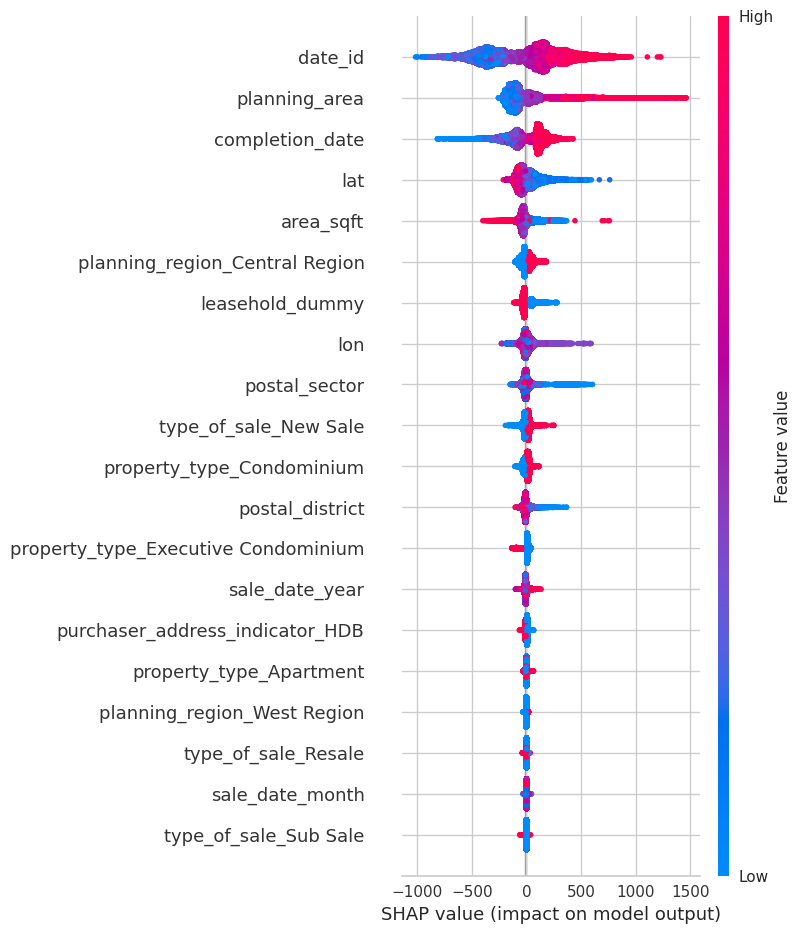

In [ ]:
# Interpret the SHAP result of the best model
reg_exp.interpret_model(xgboost_model)

## Step 6: Improve the solution
- More data and more relevant features
- Use stacking or blending ensembles
- Tune the model hyperparameters
- Insert more intermediate steps into the ML pipeline
- Better explanation

In [ ]:
# Train a stacking ensemble
from pycaret.regression import load_model,save_model
try:
    stacked_model = load_model(model_dir/'stacked_model')
except FileNotFoundError:
    print("Model file does not exist.")
    stacked_model = reg_exp.stack_models([rf_model,xgboost_model,catboost_model,lightgbm_model])
    save_model(stacked_model, model_dir/'stacked_model')

#log model in mlflow
# with mlflow.start_run(nested=True):
#     mlflow.sklearn.log_model(
#         sk_model=stacked_model,
#         artifact_path="stacked_model"
#     )

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,66.3615,10166.0497,100.8268,0.9703,0.0847,0.0621
1,67.0830,10799.7822,103.9220,0.9686,0.0858,0.0626
2,66.8204,10668.5511,103.2887,0.9694,0.0844,0.0617
3,67.0341,10638.4409,103.1428,0.9691,0.0852,0.0624
4,67.5118,10833.8301,104.0857,0.9685,0.0863,0.0627
5,67.3860,10706.9531,103.4744,0.9684,0.0863,0.0630
6,66.8590,10474.0766,102.3429,0.9697,0.0859,0.0625
7,66.9481,10489.1600,102.4166,0.9696,0.0847,0.0621
8,66.9186,10491.0874,102.4260,0.9696,0.0866,0.0628


Transformation Pipeline and Model Successfully Saved


In [ ]:
# Train a blending ensemble
from pycaret.regression import load_model,save_model
try:
    blend_model = load_model(model_dir/'blend_model')
except FileNotFoundError:
    print("Model file does not exist.")
    blend_model = reg_exp.blend_models([rf_model,xgboost_model,catboost_model,lightgbm_model])
    save_model(blend_model, model_dir/'blend_model')

#log model in mlflow
# with mlflow.start_run(nested=True):
#     mlflow.sklearn.log_model(
#         sk_model=blend_model,
#         artifact_path="blend_model"
#     )

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,72.6823,12001.0315,109.5492,0.9650,0.0918,0.0681
1,73.5311,12838.7895,113.3084,0.9627,0.0933,0.0687
2,73.5079,12745.2742,112.8950,0.9634,0.0917,0.0679
3,73.1282,12412.7846,111.4127,0.9639,0.0923,0.0683
4,73.7259,12673.5814,112.5770,0.9632,0.0930,0.0685
5,73.7121,12632.0138,112.3922,0.9627,0.0933,0.0690
6,73.9665,12595.1413,112.2281,0.9635,0.0936,0.0691
7,73.5666,12500.2746,111.8046,0.9638,0.0922,0.0683
8,73.4024,12530.7567,111.9409,0.9637,0.0934,0.0686


Transformation Pipeline and Model Successfully Saved


In [ ]:
# Tune the best model so far (random forest so far but not working)
from pycaret.regression import load_model,save_model
try:
    tuned_model = load_model(model_dir/'tuned_model')
except FileNotFoundError:
    print("Model file does not exist.")
    tuned_model = reg_exp.tune_model(xgboost_model)
    save_model(tuned_model, model_dir/'tuned_model')

#log model in mlflow
# with mlflow.start_run(nested=True):
#     mlflow.sklearn.log_model(
#         sk_model=tuned_model,
#         artifact_path="tuned_model"
#     )

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,61.0174,8696.5674,93.2554,0.9746,0.0790,0.0571
1,61.1344,8978.6533,94.7558,0.9739,0.0790,0.0571
2,61.2048,8946.4229,94.5855,0.9743,0.0781,0.0566
3,61.0556,8863.9434,94.1485,0.9742,0.0786,0.0570
4,61.4862,9102.7002,95.4081,0.9736,0.0794,0.0570
5,61.4370,9120.6123,95.5019,0.9731,0.0796,0.0573
6,61.7389,9018.9824,94.9683,0.9739,0.0801,0.0577
7,61.4432,8823.4854,93.9334,0.9744,0.0782,0.0570
8,60.9453,8751.6143,93.5501,0.9747,0.0797,0.0571


Fitting 10 folds for each of 10 candidates, totalling 100 fits
Transformation Pipeline and Model Successfully Saved


In [ ]:
# Check the test performance if one of the above outperforms the previous ones
stacked_model_perf = reg_exp.predict_model(stacked_model)
print(stacked_model_perf[['price_psf', 'prediction_label']])

blend_model_perf = reg_exp.predict_model(blend_model)
print(blend_model_perf[['price_psf', 'prediction_label']])

tuned_model_perf = reg_exp.predict_model(tuned_model)
print(tuned_model_perf[['price_psf', 'prediction_label']])

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Stacking Regressor,67.0598,10730.7768,103.5895,0.9688,0.0855,0.0623


        price_psf  prediction_label
459641   611.0000          560.0385
517902  2084.0000         1890.0845
295725   453.0000          426.5839
474001   798.0000          782.0288
508782  1184.0000         1136.7301
...           ...               ...
204465   653.0000          686.2271
20668   1584.0000         1786.3305
101121  1947.0000         2187.1288
275604   886.0000         1160.6949
538098  1507.0000         1474.9398

[172077 rows x 2 columns]


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Voting Regressor,73.5703,12639.3272,112.4248,0.9632,0.0930,0.0686


        price_psf  prediction_label
459641   611.0000          559.8189
517902  2084.0000         1794.3384
295725   453.0000          489.6129
474001   798.0000          787.0037
508782  1184.0000         1163.9409
...           ...               ...
204465   653.0000          681.8146
20668   1584.0000         1763.7725
101121  1947.0000         2304.0189
275604   886.0000         1132.1070
538098  1507.0000         1487.1534

[172077 rows x 2 columns]


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Extreme Gradient Boosting,60.8830,8846.6191,94.0565,0.9743,0.0788,0.0568


        price_psf  prediction_label
459641   611.0000          603.0045
517902  2084.0000         1788.8640
295725   453.0000          432.4008
474001   798.0000          785.7145
508782  1184.0000         1133.7601
...           ...               ...
204465   653.0000          666.6994
20668   1584.0000         1734.4341
101121  1947.0000         2077.8733
275604   886.0000          965.1762
538098  1507.0000         1477.2952

[172077 rows x 2 columns]


In [ ]:
# The often reported metric for real estate autovaluation is MAPD

import numpy as np

print("============================== stacked_model_perf ==============================")

# ## First, compute the percentage absolute errors
stacked_model_perf['percentage_absolute_error'] = np.where(
    stacked_model_perf['price_psf'] != 0,
    abs((stacked_model_perf['price_psf'] - stacked_model_perf['prediction_label']) / stacked_model_perf['price_psf']) * 100,
    np.nan  # or any other placeholder for undefined PAE
)

# ## Next, take the median of these errors and report the MAPD
MAPD = stacked_model_perf['percentage_absolute_error'].median()

print(stacked_model_perf[['price_psf', 'prediction_label', 'percentage_absolute_error']])
print(f"The Median Absolute Percentage Deviation (MAPD) pf stacked_model_perf is {MAPD:.2f}%")

============================== stacked_model_perf ==============================
        price_psf  prediction_label  percentage_absolute_error
459641   611.0000          560.0385                     8.3407
517902  2084.0000         1890.0845                     9.3050
295725   453.0000          426.5839                     5.8314
474001   798.0000          782.0288                     2.0014
508782  1184.0000         1136.7301                     3.9924
...           ...               ...                        ...
204465   653.0000          686.2271                     5.0884
20668   1584.0000         1786.3305                    12.7734
101121  1947.0000         2187.1288                    12.3333
275604   886.0000         1160.6949                    31.0039
538098  1507.0000         1474.9398                     2.1274

[172077 rows x 3 columns]
The Median Absolute Percentage Deviation (MAPD) pf stacked_model_perf is 4.55%


In [ ]:
# The often reported metric for real estate autovaluation is MAPD

import numpy as np

print("============================== blend_model_perf ==============================")

# ## First, compute the percentage absolute errors
blend_model_perf['percentage_absolute_error'] = np.where(
    blend_model_perf['price_psf'] != 0,
    abs((blend_model_perf['price_psf'] - blend_model_perf['prediction_label']) / blend_model_perf['price_psf']) * 100,
    np.nan  # or any other placeholder for undefined PAE
)

# ## Next, take the median of these errors and report the MAPD
MAPD = blend_model_perf['percentage_absolute_error'].median()

print(blend_model_perf[['price_psf', 'prediction_label', 'percentage_absolute_error']])
print(f"The Median Absolute Percentage Deviation (MAPD) pf blend_model_perf is {MAPD:.2f}%")

============================== blend_model_perf ==============================
        price_psf  prediction_label  percentage_absolute_error
459641   611.0000          559.8189                     8.3766
517902  2084.0000         1794.3384                    13.8993
295725   453.0000          489.6129                     8.0823
474001   798.0000          787.0037                     1.3780
508782  1184.0000         1163.9409                     1.6942
...           ...               ...                        ...
204465   653.0000          681.8146                     4.4127
20668   1584.0000         1763.7725                    11.3493
101121  1947.0000         2304.0189                    18.3369
275604   886.0000         1132.1070                    27.7773
538098  1507.0000         1487.1534                     1.3170

[172077 rows x 3 columns]
The Median Absolute Percentage Deviation (MAPD) pf blend_model_perf is 5.02%


In [ ]:
# The often reported metric for real estate autovaluation is MAPD

import numpy as np

print("============================== tuned_model_perf ==============================")

# ## First, compute the percentage absolute errors
tuned_model_perf['percentage_absolute_error'] = np.where(
    tuned_model_perf['price_psf'] != 0,
    abs((tuned_model_perf['price_psf'] - tuned_model_perf['prediction_label']) / tuned_model_perf['price_psf']) * 100,
    np.nan  # or any other placeholder for undefined PAE
)

# ## Next, take the median of these errors and report the MAPD
MAPD = tuned_model_perf['percentage_absolute_error'].median()

print(tuned_model_perf[['price_psf', 'prediction_label', 'percentage_absolute_error']])
print(f"The Median Absolute Percentage Deviation (MAPD) pf tuned_model_perf is {MAPD:.2f}%")

============================== tuned_model_perf ==============================
        price_psf  prediction_label  percentage_absolute_error
459641   611.0000          603.0045                     1.3086
517902  2084.0000         1788.8640                    14.1620
295725   453.0000          432.4008                     4.5473
474001   798.0000          785.7145                     1.5395
508782  1184.0000         1133.7601                     4.2432
...           ...               ...                        ...
204465   653.0000          666.6994                     2.0979
20668   1584.0000         1734.4341                     9.4971
101121  1947.0000         2077.8733                     6.7218
275604   886.0000          965.1762                     8.9364
538098  1507.0000         1477.2952                     1.9711

[172077 rows x 3 columns]
The Median Absolute Percentage Deviation (MAPD) pf tuned_model_perf is 4.12%


## Step 7: Maintain a proper pipeline management
- MLOps to manage data and model versions, performance, and other related artifacts


In [ ]:
# Call the value of NGROK_AUTHTOKEN from colab secrets
try:
  from google.colab import userdata
  NGROK_AUTHTOKEN = userdata.get('NGROK_AUTHTOKEN')
except ModuleNotFoundError:
  NGROK_AUTHTOKEN = "2obUBqDZT160vrU9R4z3ri1PF0l_65yRXm593d6DZ6KeybkFi"

# Add the auth-token to system
!ngrok config add-authtoken $NGROK_AUTHTOKEN

Authtoken saved to configuration file: /home/dannel/.config/ngrok/ngrok.yml


In [ ]:
from pyngrok import ngrok

# Terminate open tunnels if exist
ngrok.kill()

# Setting authtoken
ngrok.set_auth_token(NGROK_AUTHTOKEN)

# Open an HTTS tunnel on port 5000 for http://localhost:5000
ngrok_tunnel = ngrok.connect(addr="5000", proto="http", bind_tls=True)
print(f'MLFlow Tracking UI: {ngrok_tunnel.public_url}')

!mlflow ui --backend-store-uri $mlrun_dir --port 5000

# Run MLflow UI in background and redirect output to nohup.out
# !nohup mlflow ui --backend-store-uri $mlrun_dir > nohup.out 2>&1 &

print("MLFlow UI is running...")


MLFlow Tracking UI: https://c882-219-75-22-160.ngrok-free.app
[2024-11-20 07:05:20 +0800] [11295] [INFO] Starting gunicorn 23.0.0
[2024-11-20 07:05:20 +0800] [11295] [INFO] Listening at: http://127.0.0.1:5000 (11295)
[2024-11-20 07:05:20 +0800] [11295] [INFO] Using worker: sync
[2024-11-20 07:05:20 +0800] [11296] [INFO] Booting worker with pid: 11296
[2024-11-20 07:05:20 +0800] [11297] [INFO] Booting worker with pid: 11297
[2024-11-20 07:05:20 +0800] [11298] [INFO] Booting worker with pid: 11298
[2024-11-20 07:05:20 +0800] [11299] [INFO] Booting worker with pid: 11299


t=2024-11-20T07:07:07+0800 lvl=warn msg="Stopping forwarder" name=http-5000-06ca81fe-6c9d-4938-adea-3202fe57b12a acceptErr="failed to accept connection: Listener closed"


^C
[2024-11-20 07:07:07 +0800] [11295] [INFO] Handling signal: int
[2024-11-20 07:07:07 +0800] [11296] [INFO] Worker exiting (pid: 11296)
[2024-11-20 07:07:07 +0800] [11297] [INFO] Worker exiting (pid: 11297)
[2024-11-20 07:07:07 +0800] [11299] [INFO] Worker exiting (pid: 11299)
[2024-11-20 07:07:07 +0800] [11298] [INFO] Worker exiting (pid: 11298)
MLFlow UI is running...


In [ ]:
# To terminate MLFlow and release ngrok
# mlflow_process.terminate()
# ## Remove all Python processes containing "mlflow"
!pkill -f mlflow

# ## Remove all ngrok tunnels
ngrok.kill()

## Step 8: Prepare for deployment
- Train the model on all data
- Save the trained model into a file or
- Use MLFlow model versioning

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from mlflow.models import infer_signature

with mlflow.start_run() as run:
  # Finalize the model by training it with all data
  final_model = reg_exp.finalize_model(tuned_model)

  # Save the final model
  # ## Use datetime.now() to ensure that we can trace every model version
  model_filename = f'final_model_{datetime.datetime.now().strftime("%Y%m%d-%H%M%S")}'

  # ## Save the model
  reg_exp.save_model(final_model,model_dir/model_filename)

  # Splitting the data into features (X) and target (y)
  df_copy = df.sample(frac=0.1)
  X = df_copy.drop(columns=[
        'no_of_units',
        'project_name',
        'address',
        'transacted_price',
        'nett_price',
        'price_psm',
        'tenure',
        'postal_code',
        'type_of_area',
        'price_psf'
  ])  # Drop irrelevant features
  y = df_copy["price_psf"]

  # Train-test split
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

  # Infer the model signature
  y_pred = final_model.predict(X_test)
  signature = infer_signature(X_test, y_pred)

  # Compute all relevant metrics
  mae = mean_absolute_error(y_test, y_pred)
  mse = mean_squared_error(y_test, y_pred)
  rmse = np.sqrt(mse)
  r2 = r2_score(y_test, y_pred)
  rmsle = np.sqrt(mean_squared_error(np.log1p(y_test), np.log1p(y_pred)))
  mape = np.mean(np.abs((y_test - y_pred) / y_test)) * 100

   # Log metrics
  mlflow.log_metrics({
      f"{model_filename}_mae": mae,
      f"{model_filename}_mse": mse,
      f"{model_filename}_rmse": rmse,
      f"{model_filename}_r2": r2,
      f"{model_filename}_rmsle": rmsle,
      f"{model_filename}_mape": mape
  })

  # Log the sklearn model and register as version 1
  mlflow.sklearn.log_model(
      sk_model=final_model,
      artifact_path=model_filename,
      signature=signature,
      registered_model_name=model_filename,
  )
mlflow.end_run()

Transformation Pipeline and Model Successfully Saved


Successfully registered model 'final_model_20241120-160540'.
Created version '1' of model 'final_model_20241120-160540'.


## Step 9: Create an interface for ease of use
- API service
- Dashboard

### Test the prediction workflow

In [ ]:
# Randomly query one observation
import pandas as pd

test_observation = df.sample(1)  # Sample 1 row

# Display the observation
print(test_observation)
print(f"price_psf: {test_observation['price_psf'].iloc[0]}")

         project_name  transacted_price  area_sqft  price_psf  sale_date  \
459641  MARYLAND PARK      1000000.0000  1636.1300   611.0000 1996-07-25   

                       address type_of_sale type_of_area  area_sqm  price_psm  \
459641  9 AMBER GARDENS #03-11       Resale       Strata  152.0000  6579.0000   

       nett_price property_type  no_of_units    tenure  completion_date  \
459641          -     Apartment            1  Freehold        1981.0000   

       purchaser_address_indicator  postal_code  postal_district  \
459641                         HDB  439958.0000               15   

        postal_sector planning_region  planning_area  date_id  \
459641             43  Central Region  Marine Parade      375   

        leasehold_dummy    lat      lon  
459641                0 1.3015 103.8988  
price_psf: 611.0


In [ ]:
# Create a sample data input without
# ## the ignored variables and
# ## the outcome variable

# Define the variables to ignore
ignored_columns = [
    'no_of_units',
    'project_name',
    'address',
    'transacted_price',
    'nett_price',
    'price_psm',
    'tenure',
    'postal_code',
    'type_of_area',
    'price_psf'  # Exclude the outcome variable as well
]

# Create the sample input data
sample_input = test_observation.drop(columns=ignored_columns)

# Display the first few rows
print(sample_input.head())

        area_sqft  sale_date type_of_sale  area_sqm property_type  \
459641  1636.1300 1996-07-25       Resale  152.0000     Apartment   

        completion_date purchaser_address_indicator  postal_district  \
459641        1981.0000                         HDB               15   

        postal_sector planning_region  planning_area  date_id  \
459641             43  Central Region  Marine Parade      375   

        leasehold_dummy    lat      lon  
459641                0 1.3015 103.8988  


In [ ]:
from pycaret.regression import load_model, predict_model
import pandas as pd

# Load the latest trained model
model = load_model(model_dir/model_filename)

# Convert input data into pandas DataFrame
input_df = pd.DataFrame(sample_input)

# Get predicted value
predicted = predict_model(model, data=input_df)

Transformation Pipeline and Model Successfully Loaded


In [ ]:
# Insert prediction code into a string output
predicted_value = predicted['prediction_label'].iloc[0]
print(f"Predicted Value: {predicted_value}")

Predicted Value: 615.14599609375


### Create an interface

In [ ]:
# To be covered in the next session